In [1]:
import os
import requests as req

def download_price_data(ticker):
    # Load environment variables
    # Read .env file manually and set environment variables
    with open('.env') as f:
        for line in f:
            key, value = line.strip().split('=')
            os.environ[key] = value
    # Get API_KEY from .env file
    API_KEY = os.getenv("API_KEY")
    # Save CSV file if it doesn't exist
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY_ADJUSTED&symbol={ticker}&apikey={API_KEY}&datatype=csv'
    filename = f"monthly_adjusted_{ticker}.csv"
    if not os.path.exists(filename):
        with open(filename, 'wb') as f:
            # Ensure the request was successful
            r = req.get(url)
            r.raise_for_status()
            f.write(r.content)

In [2]:
import pandas as pd

def load_source_data(prices_file, bigmac_file, start_date):
    # Stock prices
    ts = pd.read_csv(prices_file)
    ts = ts.sort_values(by="timestamp")
    ts = ts.reset_index()
    ts = ts.drop(columns="index")
    df = pd.DataFrame({
    "timestamp": ts["timestamp"],
    "price": ts["adjusted close"],
    "dividend yield": ts["dividend amount"] / ts["close"],
    })
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Big Mac index
    bigmac_pricedata = pd.read_csv(bigmac_file)
    country = "United States"
    bmprice = bigmac_pricedata[bigmac_pricedata.name == country][['date', 'dollar_price']]
    bmprice['date'] = pd.to_datetime(bmprice['date'])
    bmprice.rename(columns={"date": "timestamp", "dollar_price": "cpi"}, inplace=True)
    # Big Mac index ending date plus six months
    # The Big Mac index is published every six months, so we need to extend the last date by six months
    bmprice_end = bmprice['timestamp'].iloc[-1] + pd.DateOffset(months=6)
    # Discard data that is not in the same time range for both datasets
    bmprice = bmprice[(bmprice['timestamp'] >= df['timestamp'].iloc[0]) & (bmprice['timestamp'] <= df['timestamp'].iloc[-1])]
    df = df[(df['timestamp'] >= bmprice['timestamp'].iloc[0]) & (df['timestamp'] <= bmprice_end)]
    
    # Select data from start_date
    start_date = pd.to_datetime(start_date)
    bmprice = bmprice[bmprice['timestamp'] >= start_date]
    df = df[df['timestamp'] >= start_date]

    # Merge datasets
    df = pd.merge_asof(df, bmprice, on="timestamp")
    # Normalize CPI to 1 and stock price to 100
    df['cpi'] = df['cpi'].fillna(bmprice['cpi'].iloc[0])
    df['cpi'] = (df['cpi'] / df['cpi'].iloc[0]).round(3)
    df['price'] = (df['price'] / df['price'].iloc[0] * 100).round(3)
    return df

In [3]:
def process_strategy(df: pd.DataFrame, initial_investment: float, dividend_tax: float, capital_gains_tax: float):
    # Define a function to transform a row (month) of the time series
    def transform_row(current_month: pd.Series, previous_month: pd.Series | None, first_month: pd.Series | None):
        month = current_month.copy()
        # Initialize new columns, avoid NaNs
        month['shares sold'] = 0
        month['capital gains'] = 0
        month['capital gains tax'] = 0
        month['shares purchased'] = 0

        month['shares'] = initial_investment / month['price'] if previous_month is None else previous_month['shares']
        month['cum capital losses'] = 0 if previous_month is None else previous_month['cum capital losses']
        month['cost basis rate'] = month['price'] if previous_month is None else previous_month['cost basis rate']
        month['portfolio value'] = month['shares'] * month['price']
        # Target income
        month['gross income'] = month['portfolio value'] * month['perc. sold']

        # Receive dividends
        month['gross dividend'] = month['shares'] * month['dividend yield'] * month['price']
        month['dividend tax'] = month['gross dividend'] * dividend_tax
        month['net dividend'] = month['gross dividend'] * (1 - dividend_tax)
        
        if month['gross income'] > month['net dividend']:
            # Dividends do not cover the entire target income
            # Use dividends to cover part of the target income
            remaining_target_income = month['gross income'] - month['net dividend']
            # Sell shares to cover the remaining target income
            month['shares sold'] = remaining_target_income / month['price']
            month['shares'] -= month['shares sold']
            month['capital gains'] = month['shares sold'] * (month['price'] - month['cost basis rate'])

            if month['capital gains'] < 0:
                month['cum capital losses'] -= month['capital gains']
                month['capital gains tax'] = 0
            elif month['cum capital losses'] > 0:
                net_capital_gains = month['capital gains'] - month['cum capital losses']
                if net_capital_gains < 0:
                    month['cum capital losses'] = -net_capital_gains
                    month['capital gains tax'] = 0
                else:
                    month['capital gains tax'] = net_capital_gains * capital_gains_tax
                    month['cum capital losses'] = 0
            else:
                month['capital gains tax'] = month['capital gains'] * capital_gains_tax

            month['net income'] = month['gross income'] - month['capital gains tax']
        else:
            # Dividends cover the entire target income
            # Buy shares with remaining dividends and update cost basis rate
            remaining_dividend_income = month['net dividend'] - month['gross income']
            month['shares purchased'] = remaining_dividend_income / month['price']
            month['cost basis rate'] = (month['shares'] * month['cost basis rate'] + month['shares purchased'] * month['price']) / (month['shares'] + month['shares purchased'])
            month['shares'] += month['shares purchased']
            month['net income'] = month['gross income']
        
        month['portfolio value'] = month['shares'] * month['price']
        month['infl. adj. portfolio value'] = month['portfolio value'] / month['cpi']
        month['infl. adj. net income'] = month['net income'] / month['cpi']

        first_month = first_month if first_month is not None else month
        month['infl. adj. portfolio growth'] = month['infl. adj. portfolio value'] / first_month['infl. adj. portfolio value']
        month['infl. adj. net income growth'] = month['infl. adj. net income'] / first_month['infl. adj. net income']
        return month
    
    # Initialize an empty list to store new time series values
    new_time_series = []

    # Iterate over the DataFrame
    for i in range(len(df)):
        current_row = df.iloc[i]
        if len(new_time_series) == 0:
            previous_row = None
            first_row = None
        else:
            previous_row = new_time_series[-1]
            first_row = new_time_series[0]
        # Apply the transformation function
        new_row_value = transform_row(current_row, previous_row, first_row)
        new_time_series.append(new_row_value)

    # Create a new DataFrame for the new time series
    new_df = pd.DataFrame(new_time_series, index=df.index)
    return new_df

In [4]:
def annualize(df: pd.DataFrame):
    period_months = 12
    dfs = [df[i:i+period_months] for i in range(0, df.shape[0], period_months)]
    dfs = [df for df in dfs if df.shape[0] == period_months]
    yearly = pd.DataFrame({
        "timestamp": [d["timestamp"].iloc[-1] for d in dfs],
        "price": [d["price"].iloc[-1] for d in dfs],
        "cpi": [d["cpi"].iloc[-1] for d in dfs],
        "shares": [d["shares"].iloc[-1] for d in dfs],
        "portfolio value": [d["portfolio value"].iloc[-1] for d in dfs],
        "infl. adj. portfolio value": [d["infl. adj. portfolio value"].iloc[-1] for d in dfs],
        "infl. adj. portfolio growth": [d["infl. adj. portfolio growth"].iloc[-1] for d in dfs],
        "dividend yield": [d['dividend yield'].sum() for d in dfs],
        "dividend tax": [d["dividend tax"].sum() for d in dfs],
        "net income": [d["net income"].sum() for d in dfs],
        "infl. adj. net income": [d["infl. adj. net income"].sum() for d in dfs],
        "gross income": [d["gross income"].sum() for d in dfs],
        "capital gains tax": [d["capital gains tax"].sum() for d in dfs],
        "cost basis rate": [d["cost basis rate"].iloc[-1] for d in dfs],
    })
    yearly['infl. adj. monthly income'] = yearly['infl. adj. net income'] / period_months
    yearly['infl. adj. monthly income change'] = yearly['infl. adj. monthly income'] / yearly['infl. adj. monthly income'].iloc[0]
    yearly['tax/gross income ratio'] = (yearly['dividend tax'] + yearly['capital gains tax']) / yearly['gross income']
    return yearly

In [5]:
import matplotlib.pyplot as plt
from typing import List

def plot_results(monthly, yearly, ticker):
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))  # Adjust nrows and ncols based on the number of plots
    
    fig.suptitle(f'Portfolio performance ({ticker})')
    axs[0, 0].plot(monthly['timestamp'], monthly['price'])
    axs[0, 0].set_title('Stock Price (normalized)')
    axs[0, 1].plot(yearly['timestamp'], yearly['dividend yield'] * 100)
    axs[0, 1].set_title('Dividend yield (%)')

    axs[0, 2].plot(yearly['timestamp'], yearly['cpi'])
    axs[0, 2].set_title('Big Mac CPI')

    axs[1, 0].plot(monthly['timestamp'], monthly["infl. adj. portfolio value"])
    axs[1, 0].set_title('Inflation adjusted portfolio value')

    axs[1, 1].plot(yearly['timestamp'], yearly['infl. adj. monthly income'])
    axs[1, 1].set_title('Inflation adjusted monthly income')

    axs[1, 2].plot(yearly['timestamp'], yearly['tax/gross income ratio'])
    axs[1, 2].set_title('Tax to gross income ratio')

def plot_multiple(monthly: List[pd.DataFrame], yearly: List[pd.DataFrame], tickers: list):
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))  # Adjust nrows and ncols based on the number of plots
    [[axs[x, y].grid(axis='y') for x in range(2)] for y in range(3)] # Add horizontal grid lines
    
    fig.suptitle('Portfolio performance')
    for i, ticker in enumerate(tickers):
        axs[0, 0].plot(monthly[i]['timestamp'], monthly[i]['price'], label=ticker)
        axs[0, 0].set_title('Stock Price (normalized)')
        axs[0, 1].plot(yearly[i]['timestamp'], yearly[i]['dividend yield'] * 100, label=ticker)
        axs[0, 1].set_title('Dividend yield (%)')

        axs[0, 2].plot(yearly[i]['timestamp'], yearly[i]['cpi'], label=ticker)
        axs[0, 2].set_title('Big Mac CPI')

        axs[1, 0].plot(monthly[i]['timestamp'], monthly[i]["infl. adj. portfolio value"], label=ticker)
        axs[1, 0].set_title('Inflation adjusted portfolio value')

        axs[1, 1].plot(yearly[i]['timestamp'], yearly[i]['infl. adj. monthly income'], label=ticker)
        axs[1, 1].set_title('Inflation adjusted monthly income')

        axs[1, 2].plot(yearly[i]['timestamp'], yearly[i]['tax/gross income ratio'], label=ticker)
        axs[1, 2].set_title('Tax to gross income ratio')
    axs[0, 0].legend()
    axs[0, 1].legend()
    axs[0, 2].legend()
    axs[1, 0].legend()
    axs[1, 1].legend()
    axs[1, 2].legend()

def plot_multiple_portfolios(portfolios):
    # Run each portfolio
    for p in portfolios:
        p.run()
    monthly = [p.monthly for p in portfolios]
    yearly = [p.yearly for p in portfolios]
    tickers = [p.ticker for p in portfolios]
    plot_multiple(monthly, yearly, tickers)

In [6]:
class Portfolio():
    def __init__(self, ticker="VTI", start_date="2001-01-01", initial_investment=1000000, dividend_tax=0.26, capital_gains_tax=0.26, yearly_sale_percentage=0.04, name=None):
        self.ticker = ticker
        self.name = name if name is not None else ticker
        self.start_date = start_date
        self.initial_investment = initial_investment
        self.dividend_tax = dividend_tax
        self.capital_gains_tax = capital_gains_tax
        self.yearly_sale_percentage = yearly_sale_percentage
        self.bigmac_file = "bigmac2.csv"
        self.src_data = None
        self.monthly = None
        self.yearly = None

    def load_data(self):
        download_price_data(self.ticker)
        self.src_data = load_source_data(f"monthly_adjusted_{self.ticker}.csv", self.bigmac_file, self.start_date)

    def process(self):
        self.monthly = self.src_data.copy()
        self.monthly['perc. sold'] = self.yearly_sale_percentage / 12
        self.monthly = process_strategy(self.monthly, self.initial_investment, self.dividend_tax, self.capital_gains_tax)
        self.yearly = annualize(self.monthly)

    def run(self):
        self.load_data()
        self.process()

    def plot(self):
        if self.monthly is None or self.yearly is None:
            self.run()
        plot_results(self.monthly, self.yearly, self.ticker)

    # Generates a new portfolio with the same parameters except for the ones passed as arguments
    def generate_new(self, **kwargs):
        new_portfolio = Portfolio(self.ticker, self.start_date, self.initial_investment, self.dividend_tax, self.capital_gains_tax)
        # Use the passed arguments to replace the attributes of the new portfolio
        for key, value in kwargs.items():
            setattr(new_portfolio, key, value)
        return new_portfolio

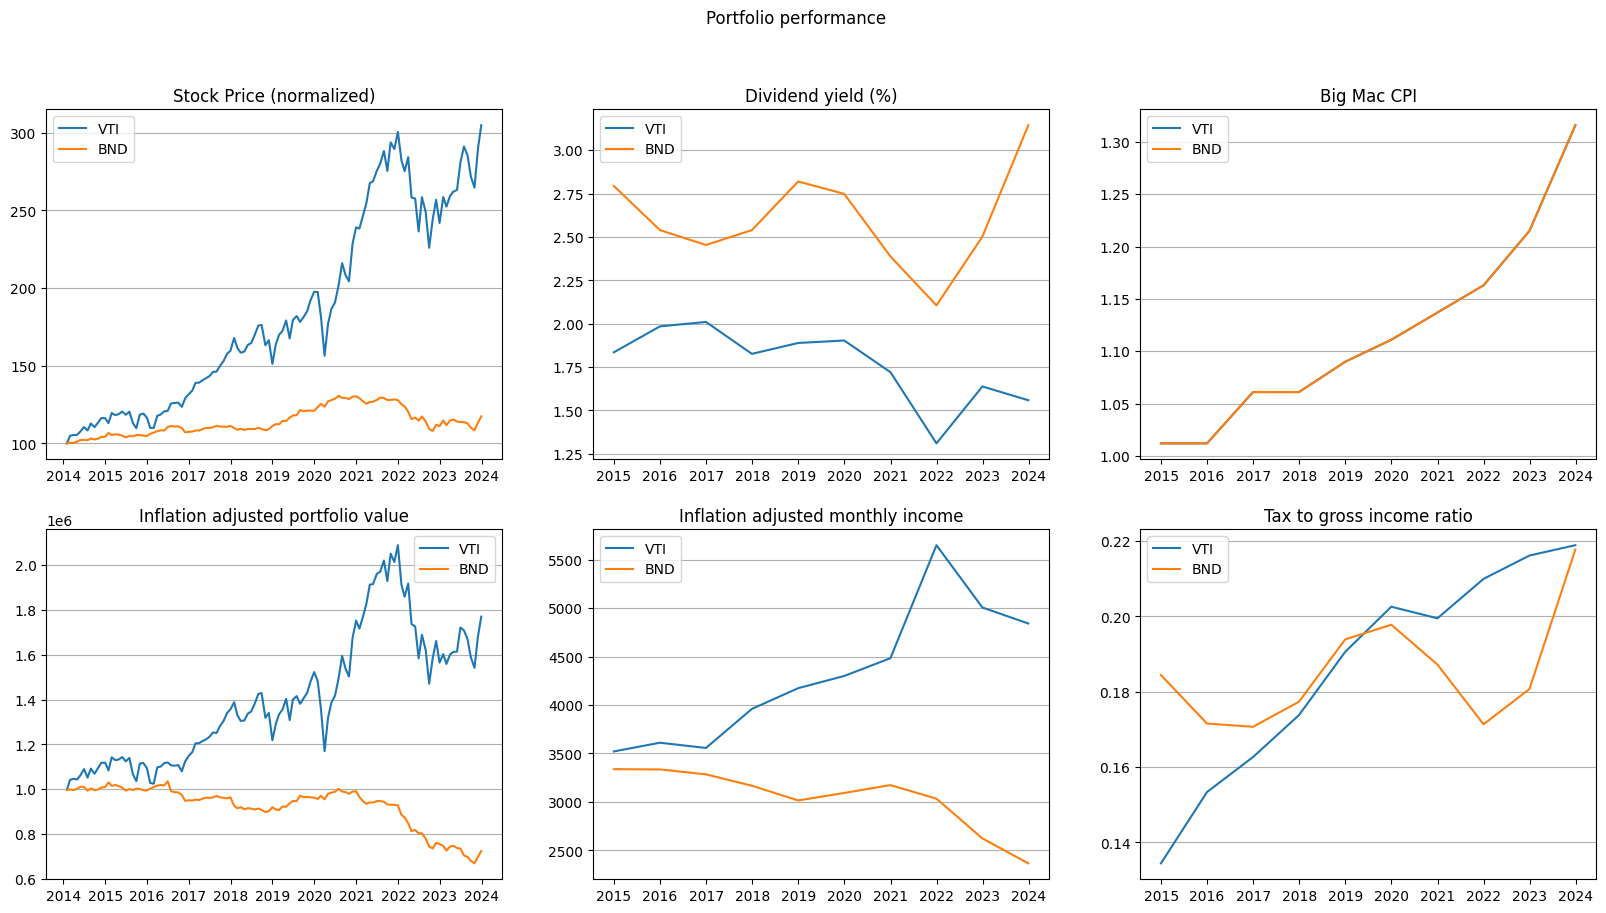

In [17]:
portfolio = Portfolio(start_date="2014-01-01")
tickers = ["VTI", "BND"]
portfolios = [portfolio.generate_new(ticker=t) for t in tickers]

plot_multiple_portfolios(portfolios)